# CMSC 320 Final Project – Checkpoint 2 (Exploratory Data Analysis)

### Information from Checkpoint 1:

#### Group Members:
 * Shreenidhi Ayinala
 * Vasu Mittal
 * Evan Solomon

##### Group Github Repo:
https://github.com/ShreenidhiAyinala/CMSC320_FinalProject

We will be exploring the Planetterp Reviews Data. This data is a collection of numerical ratings
and unstructured text regarding students’ experiences in courses at UMD, College Park.
Source domain: https://planetterp.com/

The reviews pages are not a part of the public API, so we scraped the data programmatically
from the reviews pages for all the courses on the site.
An example of a reviews page for the course CMSC420 is available at:
https://planetterp.com/course/CMSC420/reviews

##### Features of the data:
Each record is of a review left by a student, and it contains the following information/features:
- Date that the review was made
- Course Department and Number (e.g. CMSC320)
- Star rating out of 5 stars (i.e. a ‘top’ rating would be 5 stars, and the lowest rating is 1
star)
- Professor name
- Grade that the student received or is expecting to receive
- Review text – unstructured text that the reviewer can use to supplement their review

##### Size of the Data:
There are approximately 23,000 records that we collected. To the best of our knowledge, this
represents the totality of all the reviews at Planetterp.com

# Exploratory Data Analysis:

## Questions about the data that we explore:
* Is there a difference in the distribution of the ratings students give courses, between the groups of students who expect to receive an A, and those who expect to recieve a lower grade? 
* Is there a ... Vasu/Shreenidhi, please fill in...
* Is there a ... Vasu/Shreenidhi, please fill in...

In [1]:
# import packages
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns

/var/folders/8k/pw_095d94tg6j3w2wl0j_70r0000gn/T/ipykernel_63161/2918833100.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
course_reviews_data = pd.read_csv("2024_02_21_all_reviews", index_col=0)
df = pd.DataFrame(course_reviews_data)

#### Peek at the data

In [3]:
df.head()

,course_code,status_code,star_count,prof_name,prof_slug,grade,reviewer_name,date,review_text,review_id
0,NFSC112,200,4,Abani Pradhan,/professor/pradhan,Expecting an A,Anonymous,12/23/2023,"Didn't learn anything, but didn't need to. Eas...",review-31256
1,NFSC112,200,5,Qin Wang,/professor/wang_qin,Expecting an A,Anonymous,12/18/2023,Easy class. The lectures are asynchronous but ...,review-30485
2,NFSC112,200,5,Xiaoxue Jia,/professor/jia_xiaoxue,Expecting an A,Anonymous,12/13/2023,She is amazing with ADS and helpful with answe...,review-29852
3,NFSC112,200,2,Abani Pradhan,/professor/pradhan,Expecting a B-,Anonymous,12/06/2023,Easy class as long as you actually watch the l...,review-28855
4,NFSC112,200,5,Qin Wang,/professor/wang_qin,Expecting an A,Anonymous,11/26/2023,"she is a good lecturer, nfsc 112, is ""chill,"" ...",review-28192


#### Cleaning and Feature Engineering for subsequent analysis

In [4]:
# extract dept and course_num using a regular expression
df[['dept', 'course_num']] = df['course_code'].str.extract('([A-Z]{4})([0-9]+[A-Z]*)', expand=True)

# rename grade => expected_grade
df = df.rename(columns={"grade": "expected_grade"})

# convert date => datetime, and add month, year cols
df['date'] = pd.to_datetime(df['date'])
df['month'] = df.date.dt.to_period('M')
df['year'] = df.date.dt.to_period('Y')

# drop status_code, prof_slug, review_id, and course_code
df = df.loc[:, ~df.columns.isin(['status_code', 'prof_slug','review_id'])]

# convert star_count to numeric
df['star_count'] = pd.to_numeric(df['star_count'])

In [5]:
# clean up expected grades
# map letter grades to numeric
df['expected_grade'] = df['expected_grade'].str.extract('(Expecting a[n]? )([A-z0-9\-?+]{1,2})', expand=True)[1]
df.expected_grade = df.expected_grade.str.upper()

grade_mapper = {
    "A+":4.0,
    "A":4.0,
    "AA":4.0,
    "A?":4.0,
    "A-":3.7,
    "-A":3.7,
    "B+":3.3,
    "B":3.0,
    "B?":3.0,
    "B-":2.7,
    "BC":2.5,
    "CB":2.5,
    "C+":2.3,
    "C":2.0,
    "C?":2.0,
    "C-":1.7,
    "CD":1.5,
    "D+":1.3,
    "D":1.0,
    "D-":0.7,
    "F":0,
    "F+":0,
    "XF":0,
    "P":None,
    "S":None,
    "I":None,
    "-":None,
    "AU":None,
    "??":None,
    "?":None,
    "W":None
}

def map_grades_to_gpa(letter_grade):
    if pd.isna(letter_grade) or letter_grade == np.nan :
        return None
    else:
        if letter_grade.isnumeric():
            return None
        elif ( letter_grade in grade_mapper.keys()):
            return grade_mapper[letter_grade]
        else:
            print("Not in mapper: " +letter_grade)
            return None

df['gpa_grade'] = df['expected_grade'].apply(map_grades_to_gpa)


#### Peek after cleaning / feature engineering

In [6]:
df.head(5)

,course_code,star_count,prof_name,expected_grade,reviewer_name,date,review_text,dept,course_num,month,year,gpa_grade
0,NFSC112,4,Abani Pradhan,A,Anonymous,2023-12-23,"Didn't learn anything, but didn't need to. Eas...",NFSC,112,2023-12,2023,4.0
1,NFSC112,5,Qin Wang,A,Anonymous,2023-12-18,Easy class. The lectures are asynchronous but ...,NFSC,112,2023-12,2023,4.0
2,NFSC112,5,Xiaoxue Jia,A,Anonymous,2023-12-13,She is amazing with ADS and helpful with answe...,NFSC,112,2023-12,2023,4.0
3,NFSC112,2,Abani Pradhan,B-,Anonymous,2023-12-06,Easy class as long as you actually watch the l...,NFSC,112,2023-12,2023,2.7
4,NFSC112,5,Qin Wang,A,Anonymous,2023-11-26,"she is a good lecturer, nfsc 112, is ""chill,"" ...",NFSC,112,2023-11,2023,4.0


## General investigation of basic trends in the dataset:

Summary statistics on the numeric columns

In [7]:
df[["star_count", "gpa_grade"]].describe()

,star_count,gpa_grade
count,26163.000000,21817.000000
mean,3.736307,3.627598
std,1.495985,0.622104
min,1.000000,0.000000
25%,3.000000,3.300000
50%,4.000000,4.000000
75%,5.000000,4.000000
max,5.000000,4.000000


<Axes: title={'center': 'Count of Expected (gpa equivalent) Grades for all Reviews'}, xlabel='gpa_grade'>

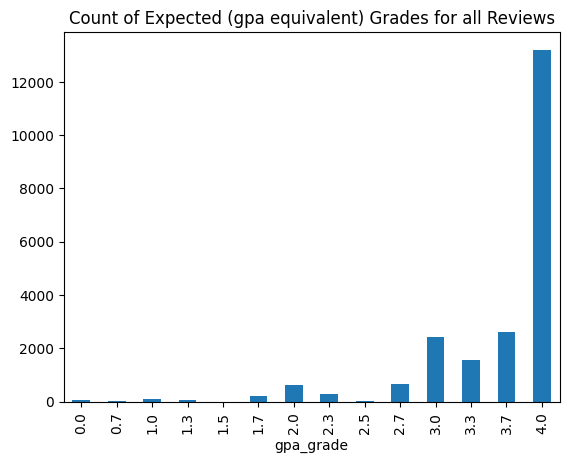

In [8]:
df['gpa_grade'].value_counts().sort_index().plot(kind="bar", title="Count of Expected (gpa equivalent) Grades for all Reviews")

We can see in the above chart, that the students who expect that they will receive a good grade, make up the vast majority of all students who leave reviews. 

<Axes: title={'center': 'Count of Number of Stars Awarded for all Reviews'}, xlabel='star_count'>

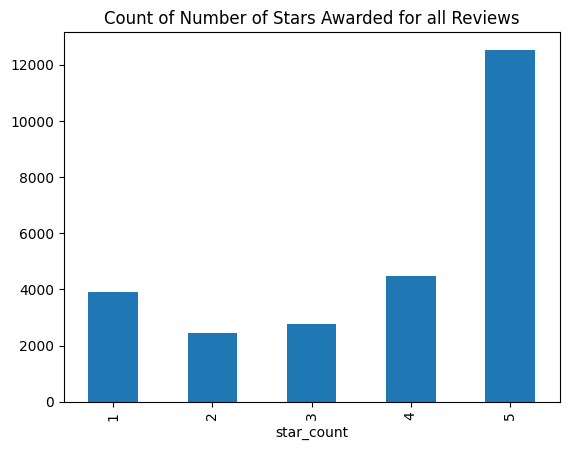

In [9]:
df.star_count.value_counts().sort_index().plot(kind="bar", title="Count of Number of Stars Awarded for all Reviews")

The chart above shows that most of the star ratings that students give to courses fall in the 5 star category, with a more even distribution for 0 to 4 stars. 

<Axes: title={'center': 'Total reviews over time'}, xlabel='year'>

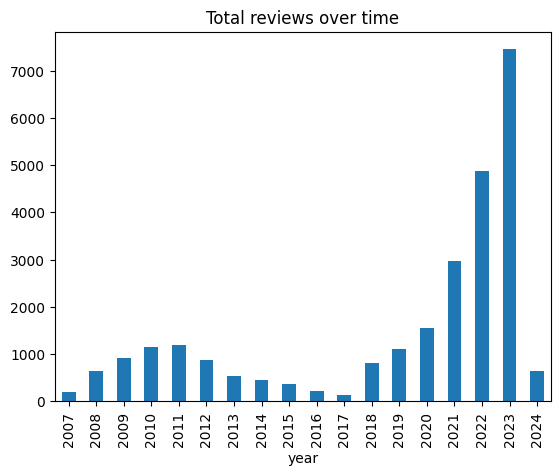

In [10]:
df.groupby('year').size().plot(kind="bar", title="Total reviews over time")

The chart above shows how the annual number of planetterp reviews has continuously, and significantly increased starting in 2021.

Out of curiosity, let's see the five most reviewed departments by year

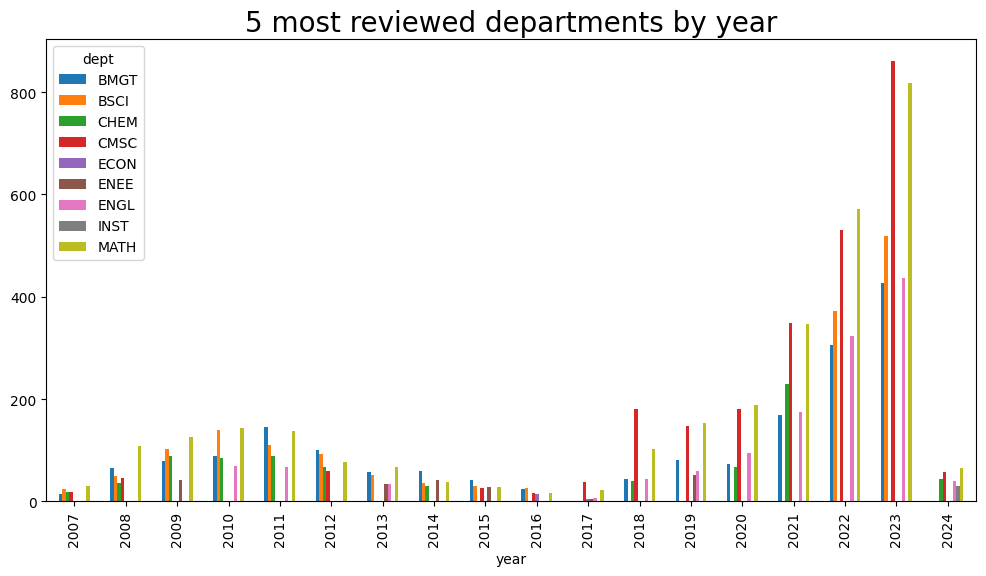

In [31]:
# 5 most reviewed departments by year
num_ratings_per_year_per_dept = df.groupby(["year", "dept"])["dept"].value_counts()
five_most_rated_depts_by_year = num_ratings_per_year_per_dept.groupby(level=0, group_keys=False).nlargest(5)

ax = five_most_rated_depts_by_year.reset_index()\
    .pivot_table(values="count", index="year", columns="dept")\
    .plot(
        kind="bar", 
        figsize=(12, 6),
        title="5 most reviewed departments by year",
        width=0.6
    )

ax.title.set_size(20)

<Axes: title={'center': 'Mean Expected Grade and Rating over time'}, xlabel='year'>

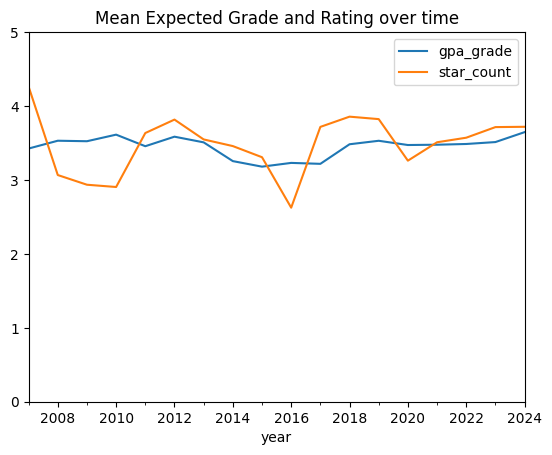

In [13]:
df[df["dept"] == "CMSC"].groupby('year')[['gpa_grade','star_count']].mean().plot( title="Mean Expected Grade and Rating over time", ylim=[0,5])

The reviewers' expected grades and course ratings appear relatively steady over time.

<Axes: title={'center': 'Difference in Review Ratings from groupings of Students separated by their expected (GPA converted) grade level.'}, xlabel='star_count'>

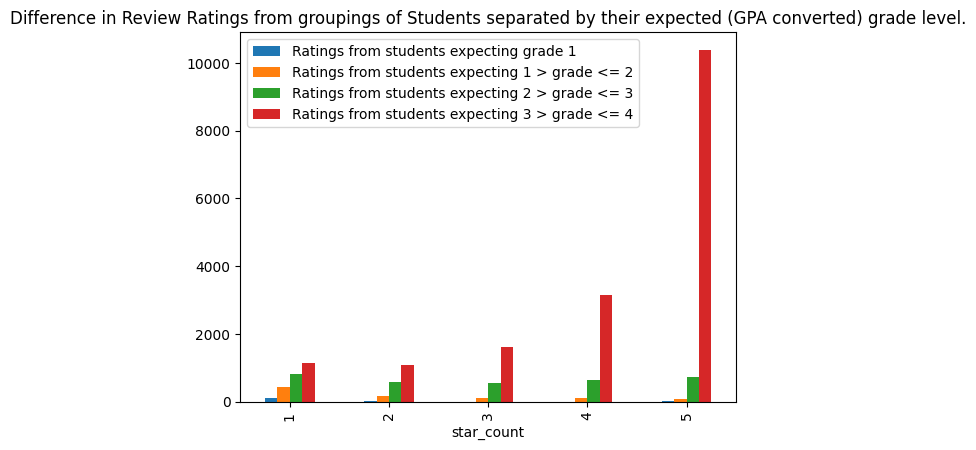

In [26]:
ratings_from_grade_earners_lte_1 = pd.Series(df[df["gpa_grade"] <= 1]["star_count"].value_counts().sort_index(),name="Ratings from students expecting grade 1")
ratings_from_grade_earners_gt_1_lte_2 = pd.Series(df[(df["gpa_grade"] > 1) & (df["gpa_grade"] <= 2)]["star_count"].value_counts().sort_index(),name="Ratings from students expecting 1 > grade <= 2")
ratings_from_grade_earners_gt_2_lte_3 = pd.Series(df[(df["gpa_grade"] > 2) & (df["gpa_grade"] <= 3)]["star_count"].value_counts().sort_index(),name="Ratings from students expecting 2 > grade <= 3")
ratings_from_grade_earners_gt_3_lte_4 = pd.Series(df[(df["gpa_grade"] > 3) & (df["gpa_grade"] <= 4)]["star_count"].value_counts().sort_index(),name="Ratings from students expecting 3 > grade <= 4")

crosstab_four_groups = pd.concat([
    ratings_from_grade_earners_lte_1,
    ratings_from_grade_earners_gt_1_lte_2,
    ratings_from_grade_earners_gt_2_lte_3,
    ratings_from_grade_earners_gt_3_lte_4
], axis=1)
crosstab_four_groups.plot(kind="bar", title="Difference in Review Ratings from groupings of Students separated by their expected (GPA converted) grade level.")

For the chart above, we have grouped reviewers into four groups based on their expected (GPA converted) grade. This chart indicates that the students expecting higher grades overwhelmingly are giving courses higher ratings (5 and 4 star ratings).

Below, we explore a little deeper, if the difference in ratings from higher scoring students and less high scoring students, hinted at in the chart above is borne out by a chi-squared test. A grade of an A or A- translate to a grade score of >= 3.7, so we will segment reviewers into two groups that fall on either side of the A- threshold.

In [15]:
greater_than_eq_3pt7 = pd.Series(df[df["gpa_grade"] >= 3.7]["star_count"].value_counts().sort_index(),name="Ratings from Students Expecting As")
less_than_3pt7 = pd.Series(df[df["gpa_grade"] < 3.7]["star_count"].value_counts().sort_index(),name="Ratings from Students Expecting less than As")

crosstab = pd.concat([greater_than_eq_3pt7,less_than_3pt7], axis=1)
crosstab

,Ratings from Students Expecting As,Ratings from Students Expecting less than As
star_count,,
1,909,1605
2,885,984
3,1361,925
4,2796,1129
5,9868,1355


<Axes: title={'center': 'Difference in Review Ratings between: \nStudents expecting an A, and Students Expecting less than an A'}, xlabel='star_count'>

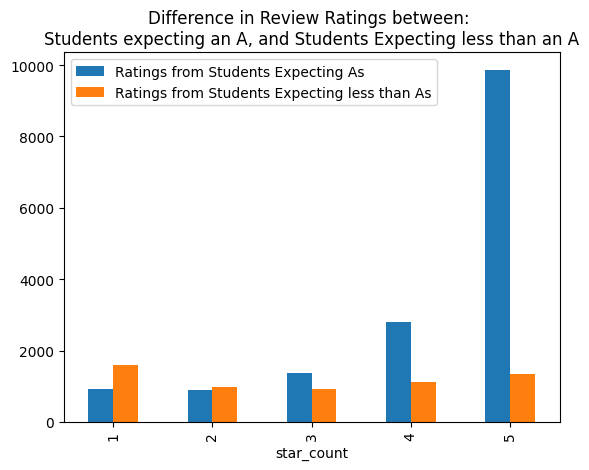

In [16]:
crosstab.plot(kind="bar", title="Difference in Review Ratings between: \nStudents expecting an A, and Students Expecting less than an A")

The difference in the distribution of star ratings is visually even more stark with just two groups of reviewers. 
Now let's investigate with a hypothesis test.
##### H0: the distribution of course ratings (star count) is the same for the groups of:
-       students who are expecting an A- or higher 
-       students who are expecting less than an A-
##### HA: the distribution of course ratings (star_count) is different for the two groups.
##### Assume alpha of .05

In [37]:
stats.chi2_contingency(crosstab)

Chi2ContingencyResult(statistic=3794.396207520017, pvalue=0.0, dof=4, expected_freq=array([[1822.84301233,  691.15698767],
       [1355.16849246,  513.83150754],
       [1657.52550763,  628.47449237],
       [2845.92634184, 1079.07365816],
       [8137.53664573, 3085.46335427]]))

Our p-value from the chi-squared test is near 0 and less than our alpha, therefore, we reject the null hypothesis.
The data indicate a statistically significant difference in the rating distributions between the two groups. 